**Используется логистическая регрессия**

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import gdown

### 1. Считывание данных + фильтрация выбросов (см. ноутбук EDA)

In [11]:
url = "https://drive.google.com/uc?id=1H0IDV40zbiJlBh5O27yfTc3wZ-23eK3Z"
output = "heart_cleveland_upload.csv"

gdown.download(url=url, output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1H0IDV40zbiJlBh5O27yfTc3wZ-23eK3Z
To: C:\Users\Clover\dgalk\ml.ai\made\2-й семестр\ML в продакшене\homework_1\notebooks\heart_cleveland_upload.csv
100%|█████████████████████████████████████████████████████████████████████████████| 11.1k/11.1k [00:00<00:00, 5.55MB/s]


'heart_cleveland_upload.csv'

In [12]:
df = pd.read_csv("heart_cleveland_upload.csv")

In [13]:
def get_whiskers(data, col_name):
    """Расчет левого и правого усов для данных из df в колонке col_name."""
    
    iqr = data.describe().loc["75%", col_name] - data.describe().loc["25%", col_name]
    
    whisker_left = data.describe().loc["25%", col_name] - 1.5 * iqr
    whisker_right = data.describe().loc["75%", col_name] + 1.5 * iqr
    
    return whisker_left, whisker_right

In [14]:
df_filtered = df[
    (df["trestbps"] <= get_whiskers(df, "trestbps")[1])
    & (df["chol"] <= get_whiskers(df, "chol")[1])
    & (df["thalach"] >= get_whiskers(df, "thalach")[0])
    & (df["oldpeak"] <= get_whiskers(df, "oldpeak")[1])
]

df_filtered.shape

(278, 14)

### 2. Разбивка на train / test

In [15]:
X = df_filtered.drop('condition', axis=1)
y = df_filtered['condition']

X.shape, y.shape

((278, 13), (278,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=17, shuffle=True
)

### 3. Обучение

In [24]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logistic_regression', LogisticRegression())
])

In [25]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [26]:
acc = pipe.score(X_test, y_test)

In [27]:
y_pred = pipe.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

In [28]:
acc, roc_auc

(0.875, 0.9106002554278416)

### 4. Важность признаков

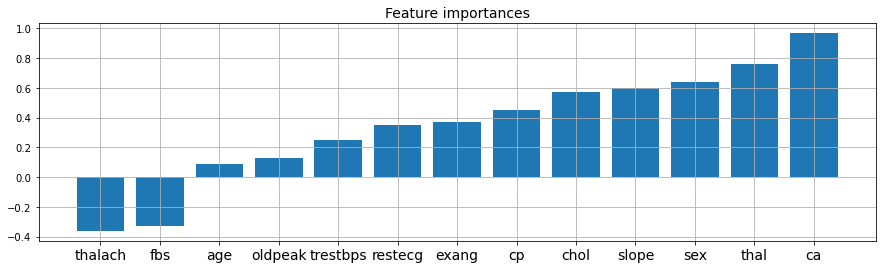

In [13]:
feats = X_train.columns
ids_sorted = np.argsort(pipe["logistic_regression"].coef_)[0]

plt.figure(figsize=(15, 4))
plt.bar(x=np.arange(len(feats)), height=pipe["logistic_regression"].coef_[0][ids_sorted])
plt.xticks(np.arange(len(feats)), feats[ids_sorted], fontsize=14);
plt.title("Feature importances", fontsize=14)
plt.grid()